In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [124]:
df = pd.read_excel('data/sales.xlsx', index_col=0)

In [125]:
df.head()

,sales_A,sales_B
day,,
1,28252,15266
2,19669,8991
3,9639,8252
4,7102,13554
5,12865,4283


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1 to 45
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sales_A  45 non-null     int64
 1   sales_B  45 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


In [127]:
df.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
           dtype='int64', name='day')

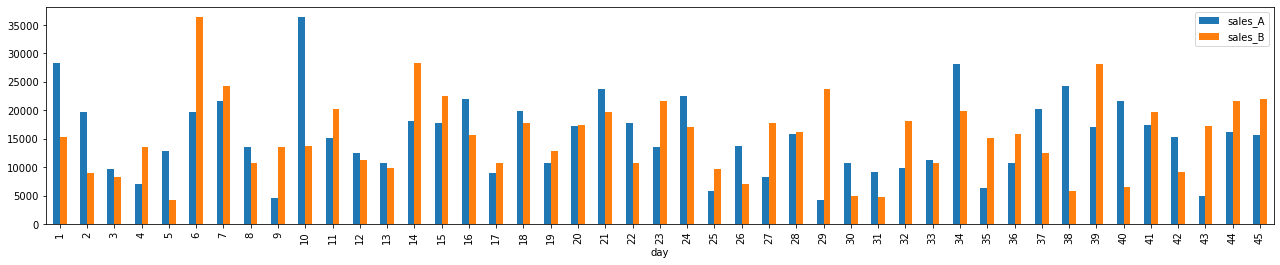

In [128]:
df.plot.bar(figsize = (22,4));

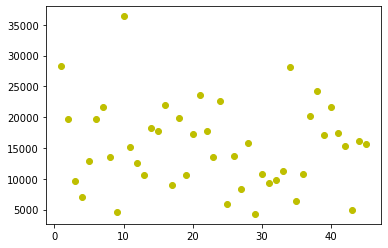

In [129]:
plt.scatter(x = df.index,y = df.sales_A, c = 'y');

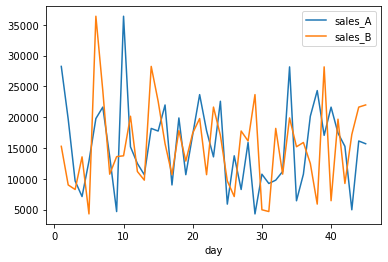

In [130]:
df.plot();

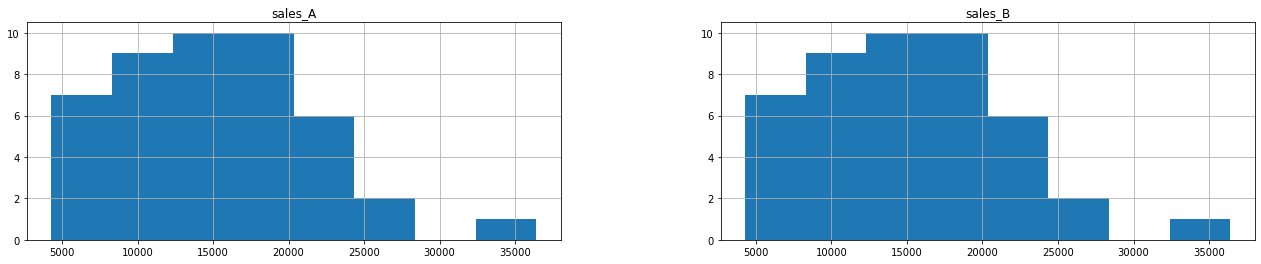

In [131]:
df.hist(bins=8,figsize = (22,4));

The first step is recognixing what sort of distribution to fit our data to. A couple of observations:

-The data are skewed, with a longer tail to the right than to the left

-The data are positive-valued, since they are measuring rainfall

-The data are continuous

In [133]:
df_mean = df.mean(axis = 0)


print(df_mean)

sales_A    15357.155556
sales_B    15360.155556
dtype: float64


In [134]:
df_var = np.var(df)
df_var1 = df.var(axis = 0, ddof=0)
print(df_var,'\n', df_var1)

sales_A    4.698664e+07
sales_B    4.698731e+07
dtype: float64 
 sales_A    4.698664e+07
sales_B    4.698731e+07
dtype: float64


We then use these moments to estimate alfa  and beta for each design(A, B):

In [135]:
alpha = df_mean ** 2 / df_var
beta = df_var / df_mean
print(alpha,'\n', beta)

sales_A    5.019347
sales_B    5.021236
dtype: float64 
 sales_A    3059.592320
sales_B    3059.038705
dtype: float64


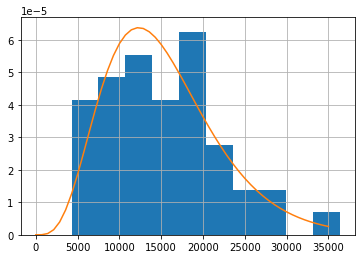

In [136]:
from scipy.stats.distributions import gamma

df.sales_A.hist(density=True);
plt.plot(np.linspace(0, 35000), gamma.pdf(np.linspace(0, 35000), a = alpha[0], loc = 0, scale = beta[0]));

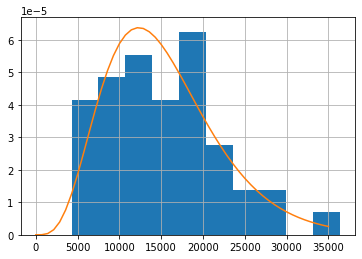

In [137]:
df.sales_B.hist(density=True);
plt.plot(np.linspace(0, 35000), gamma.pdf(np.linspace(0, 35000), a = alpha[1], loc = 0, scale = beta[1]));

In [139]:
df.std()

sales_A    6932.136270
sales_B    6932.186074
dtype: float64